### Training BERT on Labeled Endometriosis Dataset
This script trains, tests, and saves a BERT model on our labeled paragraphs (or posts) from the endometriosis dataset.

Additional resources for this code:


*   HuggingFace's docs on [fine-tuning a pre-trained model](https://huggingface.co/docs/transformers/training)
*   BERT for Humanist's [Fine-Tuning for Classification](https://colab.research.google.com/drive/19jDqa5D5XfxPU6NQef17BC07xQdRnaKU?usp=sharing) tutorial



In [1]:
import os

# Change label_class_annotations, label_type, and endo_dir to get started
label_class_annotations = 'relationships.csv'
# note: for endo support community this label_type may not work - change to spaces
label_type = "PARTNER"

# point to your project directory
endo_dir = '/content/drive/MyDrive/endometriosis/'
annotations_file_path = os.path.join(endo_dir, 'labeling', 'annotated-data', 'formatted-csvs', label_class_annotations)
model_output_path = os.path.join(endo_dir, 'code', 'output', 'PERSONAS', label_type)

In [31]:
# Basic Python modules
from collections import defaultdict
import random
import pickle

# For data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For machine learning tools and evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split

# For deep learning
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
import torch

Install the HuggingFace 🤗 transformers library

In [3]:
!pip3 install transformers

In [4]:
# using DistilBERT for testing --> can switch to BERT once set up
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [5]:
# Choose the BERT model that we want to use (make sure to keep the cased/uncased consistent)
model_name = 'distilbert-base-uncased'

# Choose the GPU we want to process this script
device_name = 'cuda'

# This is the maximum number of tokens in any document sent to BERT
max_length = 512

In [6]:
# Mount the Google drive for access to files
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Set up classification task

In [7]:
# Read in annotated data that will be used for training/testing
annotations_df = pd.read_csv(annotations_file_path)
annotations_df.sample(3)

,Unnamed: 0,id,text,url,accept,FAMILY,FRIEND,PARTNER,THERAPIST,DOCTORS,ENDO SUPPORT COMMUNITY,NON-ENDO-AUTHOR,OTHER
986,986,Endo_28oy9h_4,\nlast night I woke up with horrible pain. i c...,http://www.reddit.com/r/Endo/comments/28oy9h/s...,['FRIEND'],0,1,0,0,0,0,0,0
477,477,Endo_jzbwl1_5,2. Has anyone had a family history of these ty...,https://www.reddit.com/r/Endo/comments/jzbwl1/...,"['ENDO SUPPORT COMMUNITY', 'FAMILY']",1,0,0,0,0,1,0,0
252,252,Endo_pcg9us_0,I had a very disappointing experience at the g...,https://www.reddit.com/r/Endo/comments/pcg9us/...,['DOCTORS'],0,0,0,0,1,0,0,0


In [8]:
# Set up training and testing sets
X = annotations_df["text"].to_list()
y = annotations_df[label_type].to_list()

In [9]:
# Split dataset in train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(X, y, test_size = 0.25)

In [10]:
# Distribution of classes in train set
from collections import Counter
Counter(train_labels)

Counter({0: 708, 1: 42})

In [11]:
# Distribution of classes in test set
Counter(test_labels)

Counter({1: 15, 0: 235})

### BERT Encoding

In [12]:
# load the encoder/tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [13]:
test_texts[1:10]

['So I’ve suspected endo for many years. (I’m 20) My mom, grandma, and great grandma had it and have all had hysterectomies. I’ve told my gyno about all my symptoms (extraordinarily long periods, passing large amounts of very large clots and tissue, debilitating pain in waves that causes me to sweat bullets and almost vomit or pass out followed by diarrhea, etc.) and for several years it was pretty much brushed off since she felt no abnormalities when feeling my ovaries. Semi recently within the last few years I’ve been put on several different continuous BC pills to stop having periods. Recently I’ve started having a problem where I have breakthrough bleeding every month or so and it continues as long as I keep on the pill and only stops when I come off (my record was 3 weeks straight) But it happens so frequently I can barely get a month in without breakthrough bleeding. I’m going in to the gyno Tuesday for possibly an ultrasound. This will be my first “test” regarding endo since it’

In [14]:
# Pass training/testing sentences to tokenizer, truncate them if over max length, and add padding (PAD tokens up to 512)
train_encodings = tokenizer(train_texts,  truncation=True, padding=True)
test_encodings = tokenizer(test_texts,  truncation=True, padding=True)

## Convert into a Torch Dataset
Combine encoded text and labels into a torch dataset object.

In [15]:
class SCDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [16]:
train_dataset = SCDataset(train_encodings, train_labels)
test_dataset = SCDataset(test_encodings, test_labels)

## Set up the training task

Choose the arguments that will be used with the HuggingFace TrainingArguments object, that will be passed to the HuggingFace Trainer object.

In [17]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=50,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy='steps',
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# Load the pretrained model and send this to cuda
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased").to(device_name)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Define a custom evaluation function
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

In [20]:
# Create the trainer object based on what we've set up prior to this point!
# This combines our `model`, `training_args`, `train_dataset` and `test_dataset`, and custom evaluation function `compute_metrics`.
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,            # evaluation dataset
    compute_metrics=compute_metrics      # custom evaluation function
)

In [21]:
# Fine-tune
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy
10,0.690200,0.604709,0.940000
20,0.483600,0.327679,0.940000
30,0.214000,0.231056,0.940000
40,0.244900,0.218401,0.940000
50,0.194400,0.213165,0.940000
60,0.154800,0.219937,0.940000
70,0.179400,0.114493,0.940000
80,0.105300,0.064440,0.988000
90,0.079500,0.059719,0.988000
100,0.042500,0.043878,0.992000


TrainOutput(global_step=141, training_loss=0.18491846513240895, metrics={'train_runtime': 231.8569, 'train_samples_per_second': 9.704, 'train_steps_per_second': 0.608, 'total_flos': 298051646976000.0, 'train_loss': 0.18491846513240895, 'epoch': 3.0})

In [22]:
# built in evaluation function
trainer.evaluate()

{'eval_loss': 0.03081492707133293,
 'eval_accuracy': 0.996,
 'eval_runtime': 3.5105,
 'eval_samples_per_second': 71.215,
 'eval_steps_per_second': 3.703,
 'epoch': 3.0}

### Save the model

In [ ]:
# Check output path
model_output_path

'/content/drive/MyDrive/endometriosis/code/output/PERSONAS/PARTNER'

In [ ]:
# Save model
model.save_pretrained(model_output_path)

Configuration saved in /content/drive/MyDrive/endometriosis/code/output/PERSONAS/PARTNER/config.json
Model weights saved in /content/drive/MyDrive/endometriosis/code/output/PERSONAS/PARTNER/pytorch_model.bin


## Assess performance

In [23]:
# True labels for test set
Counter(test_labels)

Counter({1: 15, 0: 235})

In [24]:
# Predict labels for test set
predicted_labels = trainer.predict(test_dataset)

In [25]:
# Get predicted labels
actual_predicted_labels = predicted_labels.predictions.argmax(-1)
Counter(actual_predicted_labels)

Counter({1: 14, 0: 236})

In [26]:
# Another sanity check
Counter(predicted_labels.label_ids.flatten())

Counter({1: 15, 0: 235})

In [27]:
from sklearn.metrics import classification_report
print(classification_report(predicted_labels.label_ids.flatten(), actual_predicted_labels.flatten()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       235
           1       1.00      0.93      0.97        15

    accuracy                           1.00       250
   macro avg       1.00      0.97      0.98       250
weighted avg       1.00      1.00      1.00       250



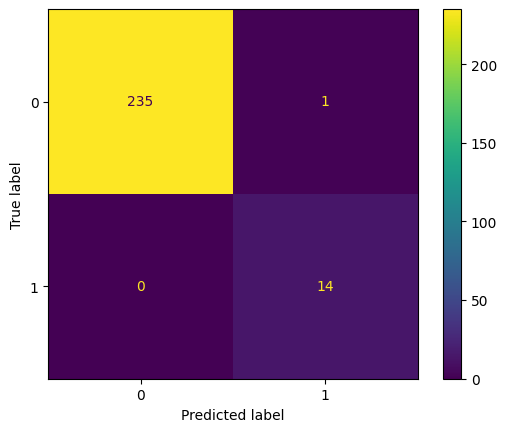

In [32]:
cm = confusion_matrix(actual_predicted_labels.flatten(), predicted_labels.label_ids.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Save of classification report
class_report = classification_report(predicted_labels.label_ids.flatten(), actual_predicted_labels.flatten(), output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df.to_csv(os.path.join(model_output_path, 'classification_report.csv'))